# MF6. Relación entre niveles medidos y calculados
* Régimen estacionario
* DISV grid

In [1]:
import flopy.mf6 as mf6
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Lectura del fichero con los niveles medidos en sondeos
(puntos de observación)
* Todos los sondeos están dentro del dominio del modelo.
* En este caso los tengo guardados en un fichero csv. 

In [2]:
fpath = r'E:\Cursos\H2OGEO\2023_Modelacion_HGeo\Ej_2\Niveles\_niveles_epsg25831_in_domain.csv'
df = pd.read_csv(fpath) 
df.head()

,sondeo,x,y,z,cnp,pnp,prof,campanya,anyo_lectura,observacio
0,SM1,432119.530805,4.591804e+06,30.309,21.809,8.5,25.0,< 2001,1999,NaN
1,SM3,432140.914559,4.591997e+06,30.465,22.965,7.5,23.0,< 2001,2005,NaN
2,SM5,432166.579268,4.592210e+06,31.177,24.177,7.0,18.5,< 2001,1999,NaN
3,SM6,432189.567023,4.592317e+06,32.000,24.500,7.5,20.0,< 2001,1999,NaN
4,SM20,432094.682088,4.591598e+06,29.255,21.255,8.0,26.0,< 2001,1990,NaN


## Rejilla del modelo

In [3]:
modelname = 'Moncada.nam'
model_ws = 'E:/Cursos/H2OGEO/2023_Modelacion_HGeo/Ej_2'
length_unit = 'm'
time_unit = 'day'

In [42]:
sim = mf6.MFSimulation.load(sim_name=modelname, exe_name='mf6', sim_ws=model_ws)

model_names = list(sim.model_names)
print('\nModel names in sim', model_names)

gwf = sim.get_model(model_names[0])

grid_type = gwf.modelgrid.grid_type
print('Type of grid:', grid_type)
    
disv = gwf.get_package('disv')
print('Number of layers:', disv.nlay)

nper = tdis.nper.get_data()
print('Number of stress periods:', nper)    

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package gnc...
    loading package oc...
    loading package chd...
    loading package wel...
    loading package riv...
    loading package rch...
  loading solution package modflow...

Model names in sim ['modflow']
Type of grid: vertex
Number of layers: {internal}
(1)

Number of stress periods: 1


## Asociar a cada sondeo la h simulada y cálculo de RMSE  

In [ ]:
# get the cell id for each point in df
cells_ids =[gwf.modelgrid.intersect(row['x'], row['y']) for index, row in df.iterrows()]

In [48]:
headfile = 'Moncada.bhd'
nlayer = 0
fresults = './calibra_estacionario/h_obs_vs_sim_disv_stationary.csv'

# create headfile object
headobj = bf.HeadFile(headfile)

# get all times
times = headobj.get_times()
if len(times) > 1:
    raise ValueError('This is not staionary simmulation')

# get the heads in a stationary simmulation
h_sim = []
for time in times:
    print(time)
    head = headobj.get_data(totim=time)
    for cell_id in cells_ids:
        h_sim.append(head[0, 0, cell_id + nlayer])

df['h_sim'] = h_sim
df['er'] = df['cnp'] - df['h_sim']
mse = ((df['er'])**2).mean()
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse} {length_unit}')

result = df[['sondeo', 'cnp', 'h_sim', 'er', 'x', 'y']]

result.to_csv(fresults, index=False)

result.head()

1.0
Root Mean Squared Error (RMSE): 2.5585012337191912 m


,sondeo,cnp,h_sim,er,x,y
0,SM1,21.809,22.950666,-1.141666,432119.530805,4.591804e+06
1,SM3,22.965,23.598200,-0.633200,432140.914559,4.591997e+06
2,SM5,24.177,24.300083,-0.123083,432166.579268,4.592210e+06
3,SM6,24.500,24.589340,-0.089340,432189.567023,4.592317e+06
4,SM20,21.255,22.222364,-0.967364,432094.682088,4.591598e+06


## Plot h medida versus calculada

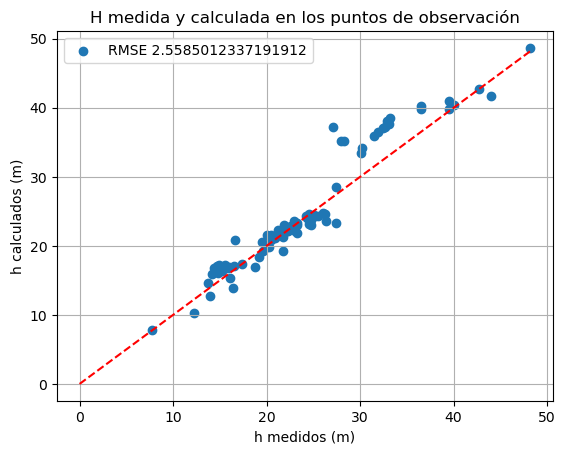

In [49]:
file_plot = './calibra_estacionario/h_observ_vs_calculada.png'

fig, ax = plt.subplots()

# Scatter plot
ax.scatter(df['cnp'], df['h_sim'], label=f'RMSE {rmse}')

# Diagonal line (1 to 1 ratio)
ax.plot([0., df['cnp'].max()], [0., df['cnp'].max()], 
        color='red', linestyle='--')

# Set plot title and axis labels
ax.set_title('H medida y calculada en los puntos de observación')
ax.set_xlabel(f'h medidos ({length_unit})')
ax.set_ylabel(f'h calculados ({length_unit})')

# Display legend
ax.legend()
ax.grid()

fig.savefig(file_plot)

# Show the plot
plt.show()
